In [605]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns

### Testing skewed normal distributions

Trying to approximate how to best estimate service time at each step. 

Reasons for this:
- There will never be a negative service time
- In reality, the service time distribution will skew right -- longer-than-expected visits are more likely than shorter-than-expected visits
- There will most likely be a minimum service time (eg minimum service of 15 minutes on an average service time of 30 minute visit) which is estimated here as having a forced minimum of half the estimated service time

Was unable to come up with a way to do this mathematically so have created instead a simulated process flow.

In [182]:
# Example: service times used for preventative care visit
n_samples = 1000
avg = 30 #Mean service time
worstcase = 30 #Worst case upper limit
std = worstcase / stats.skewnorm.ppf(1 - 0.05, avg) # Setting stdev such that 5% of visits result in worst case scenario

In [183]:
dist = stats.skewnorm.rvs(0.5, loc = avg, scale = std, size = n_samples)

Median: 35.151749262377564
Mean: 35.28818861599887
Min: -6.1152351663284605
Max: 81.19083192040627
25th percentile: 25.50017152238562
75th percentile: 44.98200700047124


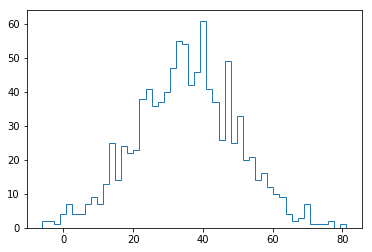

In [184]:
print ('Median:', np.median(dist))
print ('Mean:', np.mean(dist))
print ('Min:', np.min(dist))
print ('Max:', np.max(dist))
print ('25th percentile:', np.percentile(dist, 25))
print ('75th percentile:', np.percentile(dist, 75))
plt.hist(dist, histtype = 'step', bins = 50)
plt.show()

In [185]:
dist[dist < avg / 2] = avg / 2 #Remove negative / too low results

Median: 35.151749262377564
Mean: 35.824794059430964
Min: 15.0
Max: 81.19083192040627
25th percentile: 25.50017152238562
75th percentile: 44.98200700047124


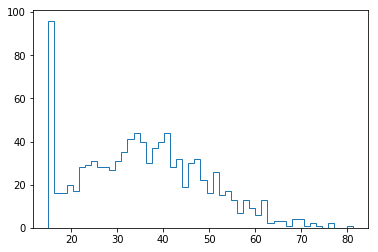

In [186]:
print ('Median:', np.median(dist))
print ('Mean:', np.mean(dist))
print ('Min:', np.min(dist))
print ('Max:', np.max(dist))
print ('25th percentile:', np.percentile(dist, 25))
print ('75th percentile:', np.percentile(dist, 75))
plt.hist(dist, histtype = 'step', bins = 50)
plt.show()

### Simulated process using skewed distributions

#### _Data tables_

In [187]:
providers = {'Doctor': 9, 'Nurse': 5, 'FlowStaff': 20, 'CSR': 10}
providers

{'Doctor': 9, 'Nurse': 5, 'FlowStaff': 20, 'CSR': 10}

In [188]:
low = 0.05
medium = 0.1
high = 0.2

In [381]:
arrival_rate = 100 / 10

In [635]:
cols = ['Type', 'Frequency', 'Time_Mean', 'Time_WorstCase', 'Perc_WorstCase']
preventative = ['Preventative', 0.2, 30, 30, low]
chronic = ['Chronic', 0.6, 30, 30, medium]
acute = ['Acute', 0.2, 15, 5, low]
base_case_types = pd.DataFrame([preventative, chronic, acute], columns = cols)

In [636]:
base_case_types['Time_Mean_hrs'] = base_case_types['Time_Mean'] / 60
base_case_types['Time_WorstCase_hrs'] = base_case_types['Time_WorstCase'] / 60

In [637]:
base_case_types

,Type,Frequency,Time_Mean,Time_WorstCase,Perc_WorstCase,Time_Mean_hrs,Time_WorstCase_hrs
0,Preventative,0.2,30,30,0.05,0.50,0.500000
1,Chronic,0.6,30,30,0.10,0.50,0.500000
2,Acute,0.2,15,5,0.05,0.25,0.083333


In [192]:
cols = ['Step', 'Process', 'Staff', 'Time_Mean', 'Time_WorstCase', 'Perc_WorstCase']
appt = ['Schedule', 'Make_appointment', 'CSR', 5, 5, low]
checkin = ['Arrive', 'Check_in', 'CSR', 2, 3, low]
wait = ['Arrive', 'Waiting_room', 'FlowStaff', 3, 5, low]
to_room = ['Arrive', 'To_exam_room', 'FlowStaff', 1, 0, low]
vitals = ['Exam_prep', 'Vitals_check', 'FlowStaff', 2, 0, low]
refine_complaint = ['Exam_prep', 'Refine_complaint', 'FlowStaff', 15, 15, high]
start_note = ['Exam_prep', 'Start_note', 'FlowStaff', 1, 0, low]
exam = ['Exam_provider', 'Exam', 'Doctor', np.nan, np.nan, np.nan] # Because simulating, to be filled on the go
checkout = ['Conclude', 'Checkout', 'CSR', 5, 5, medium]
process_flow = pd.DataFrame([appt, checkin, wait, to_room, vitals, refine_complaint, start_note, exam, checkout], columns = cols)

In [193]:
process_flow['Time_Mean_hrs'] = process_flow['Time_Mean'] / 60
process_flow['Time_WorstCase_hrs'] = process_flow['Time_WorstCase'] / 60

In [218]:
process_flow['Servers'] = process_flow['Staff'].map(providers)

In [219]:
process_flow

,Step,Process,Staff,Time_Mean,Time_WorstCase,Perc_WorstCase,Time_Mean_hrs,Time_WorstCase_hrs,Servers
0,Schedule,Make_appointment,CSR,5.0,5.0,0.05,0.083333,0.083333,10
1,Arrive,Check_in,CSR,2.0,3.0,0.05,0.033333,0.050000,10
2,Arrive,Waiting_room,FlowStaff,3.0,5.0,0.05,0.050000,0.083333,20
3,Arrive,To_exam_room,FlowStaff,1.0,0.0,0.05,0.016667,0.000000,20
4,Exam_prep,Vitals_check,FlowStaff,2.0,0.0,0.05,0.033333,0.000000,20
5,Exam_prep,Refine_complaint,FlowStaff,15.0,15.0,0.20,0.250000,0.250000,20
6,Exam_prep,Start_note,FlowStaff,1.0,0.0,0.05,0.016667,0.000000,20
7,Exam_provider,Exam,Doctor,NaN,NaN,NaN,NaN,NaN,9
8,Conclude,Checkout,CSR,5.0,5.0,0.10,0.083333,0.083333,10


#### _Simulated process_

Start after `Make_appointment` process

In [382]:
process_flow_clinic = process_flow.iloc[1:]

In [588]:
n_sims = 500

In [589]:
initial_arrivals = np.zeros(shape = n_sims)
end_served = np.zeros(shape = n_sims)
mean_serv_time = np.zeros(shape = n_sims)

for i_sim in range(n_sims) :
    served = list()
    waiting = list()
    n_arrivals = np.random.poisson(arrival_rate)
    initial_arrivals[i_sim] = n_arrivals
    
    time_thru = np.zeros(shape = n_arrivals)
    
    # Go by each process
    for p in process_flow_clinic['Process'] :
        if p == 'Exam' :
            visit_types = np.random.choice(base_case_types['Type'].values, p = base_case_types['Frequency'].values, size = n_arrivals)
            visit_dict = dict()
            for v in visit_types :
                if v in visit_dict.keys() :
                    visit_dict[v] += 1
                else :
                    visit_dict[v] = 1
            serv_time_list = list()
            for k, v in visit_dict.items() :
                proc_avg = base_case_types.loc[base_case_types['Type'] == k, 'Time_Mean_hrs'].item()
                proc_worstcase = base_case_types.loc[base_case_types['Type'] == k, 'Time_WorstCase_hrs'].item()
                proc_std = proc_worstcase / stats.skewnorm.ppf(1 - base_case_types.loc[base_case_types['Type'] == k, 'Perc_WorstCase'].item(), avg)
                proc_dist = stats.skewnorm.rvs(0.5, loc = proc_avg, scale = proc_std, size = 1000)
                proc_dist[proc_dist < proc_avg / 2] = proc_avg / 2
                serv_time_type = np.random.choice(proc_dist, size = v)
                for s in serv_time_type :
                    serv_time_list.append(s)
            serv_time = np.asarray(serv_time_list)
            
            n_servers = process_flow_clinic.loc[process_flow_clinic['Process'] == p, 'Servers'].item()
            if n_arrivals <= n_servers :
                n_served = n_arrivals
            else :
                full_serves = (n_arrivals // n_servers) + 1
                pad_resize = (full_serves * n_servers) - n_arrivals
                serv_time_pad = np.pad(serv_time, (0, pad_resize), mode = 'constant')
                reshaped_pad_serve_time = np.reshape(serv_time_pad, (full_serves, n_servers))
                total_serve_times = reshaped_pad_serve_time.sum(axis = 0)
                if any(total_serve_times > 1) :
                    for i in range(len(reshaped_pad_serve_time)) :
                        running_serve_time_cumu = reshaped_pad_serve_time[:i+1].sum(axis = 0)
                        if any(running_serve_time_cumu > 1) :
                            n_served = (n_servers - sum(running_serve_time_cumu > 1) - sum(serv_time_pad == 0) + (i * n_servers))
                else :
                    n_served = n_arrivals

            n_waiting = n_arrivals - n_served

            #Prepare transition to next step
            n_arrivals = n_served
            served.append(n_served)
            waiting.append(n_waiting)
            #NOT RIGHT WAY TO DO IT, NOT REMOVING ONE THAT ACTUALLY RAN OVER
            time_thru = time_thru[:n_served]
            time_thru += serv_time[:n_served]
        
        else :
            #Create process distribution and choose random sample of n_arrival samples from distribution
            proc_avg = process_flow_clinic.loc[process_flow_clinic['Process'] == p, 'Time_Mean_hrs'].item()
            proc_worstcase = process_flow_clinic.loc[process_flow_clinic['Process'] == p, 'Time_WorstCase_hrs'].item()
            proc_std = proc_worstcase / stats.skewnorm.ppf(1 - process_flow_clinic.loc[process_flow_clinic['Process'] == p, 'Perc_WorstCase'].item(), avg)
            proc_dist = stats.skewnorm.rvs(0.5, loc = proc_avg, scale = proc_std, size = 1000)
            proc_dist[proc_dist < proc_avg / 2] = proc_avg / 2

            #Check whether all can be served
            n_servers = process_flow_clinic.loc[process_flow_clinic['Process'] == p, 'Servers'].item()
            serv_time = np.random.choice(proc_dist, size = n_arrivals)
            if n_arrivals <= n_servers :
                n_served = n_arrivals
            else :
                full_serves = (n_arrivals // n_servers) + 1
                pad_resize = (full_serves * n_servers) - n_arrivals
                serv_time_pad = np.pad(serv_time, (0, pad_resize), mode = 'constant')
                reshaped_pad_serve_time = np.reshape(serv_time_pad, (full_serves, n_servers))
                total_serve_times = reshaped_pad_serve_time.sum(axis = 0)
                if any(total_serve_times > 1) :
                    for i in range(len(reshaped_pad_serve_time)) :
                        running_serve_time_cumu = reshaped_pad_serve_time[:i+1].sum(axis = 0)
                        if any(running_serve_time_cumu > 1) :
                            n_served = (n_servers - sum(running_serve_time_cumu > 1) - sum(serv_time_pad == 0) + (i * n_servers))
                else :
                    n_served = n_arrivals

            n_waiting = n_arrivals - n_served

            #Prepare transition to next step
            n_arrivals = n_served
            served.append(n_served)
            waiting.append(n_waiting)
            time_thru = time_thru[:n_served]
            time_thru += serv_time[:n_served]
    end_served[i_sim] = served[-1]
    mean_serv_time[i_sim] = np.mean(time_thru)

### Simulation results

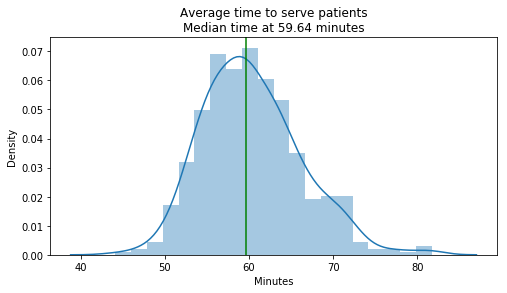

In [631]:
fig, ax = plt.subplots(figsize = (8, 4))
sns.distplot(mean_serv_time*60, ax = ax)
ax.axvline(np.median(mean_serv_time)*60, c = 'green')
ax.set_title('Average time to serve patients\nMedian time at {:.2f} minutes'.format(np.median(mean_serv_time)*60))
ax.set_xlabel('Minutes')
ax.set_ylabel('Density')
plt.show()

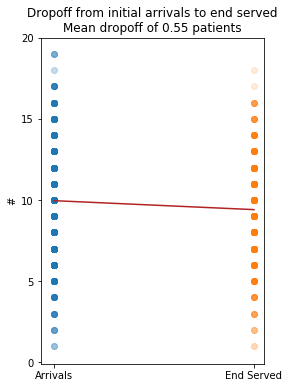

In [634]:
fig, ax = plt.subplots(figsize = (4, 6))
ax.scatter(np.zeros(shape = len(initial_arrivals)), initial_arrivals, alpha = 0.25)
ax.scatter(np.ones(shape = len(end_served)), end_served, alpha = 0.15)
ax.plot([0, 1], [np.mean(initial_arrivals), np.mean(end_served)], c = 'firebrick')
ax.set_xticks([0, 1])
ax.set_xticklabels(['Arrivals', 'End Served'])
ax.set_yticks(np.arange(0, np.max(initial_arrivals) + 5, 5))
ax.set_ylabel('#')
ax.set_title('Dropoff from initial arrivals to end served\nMean dropoff of {:.2f} patients'.format(np.mean(initial_arrivals) - np.mean(end_served)))
plt.show()